In [1]:
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


# 80.ID番号への変換

In [50]:
import pandas as pd
import torch
def word(text):
    col_names = ('id','title','url','publisher','category','entertainment','story','hostname','timestamp')
    df = pd.read_table('./gdrive/MyDrive/newsCorpora.csv',names = ('id','title','url','publisher','category','entertainment','story','hostname','timestamp'), index_col = 0)
    df = df[df['publisher'].isin(["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"])][['category','title']]
    
    res = {}
    for title in df['title']:
        for  word in title.strip().split():
            if word in res:
                res[word] += 1
            else:
                res[word] = 1
    res = sorted(res.items(), key = lambda x:x[1], reverse = True)
    wordid = {word: i + 1 for i, (word, cnt) in enumerate(res) if cnt > 1}

    df = pd.read_csv(text,sep = '\t')
    
    label = {'b':0,'t':1,'e':2,'m':3}
    df_t = [label[i] for i in df['category']]

   
   
    return df['title'], wordid ,torch.tensor(df_t)

In [52]:
df_train, train_wordid, train_t = word('./gdrive/MyDrive/train.txt')
df_valid, valid_wordid, valid_t = word('./gdrive/MyDrive/valid.txt')
df_test,  test_wordid, test_t = word('./gdrive/MyDrive/test.txt')

In [54]:
def toid(title,wordid):
    return [wordid[word] if word in wordid else 0 for word in title.split()]

def dataset_to_ids(dataset,wordid):
    return [torch.tensor(toid(x,wordid)) for x in dataset]

In [55]:
train_x = dataset_to_ids(df_train,train_wordid)
valid_x = dataset_to_ids(df_valid,valid_wordid)
test_x  = dataset_to_ids(df_test, test_wordid)

# 81.RNNによる予測

In [6]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, t):
        self.x = x
        self.t = t
        self.size = len(x)
    
    def __len__(self):
        return self.size
            
    def __getitem__(self, index):
        return [
                self.x[index],
                self.t[index]]

#    def collate_fn(batch):
#        X = pad([b[0] for b in batch], batch_first=True)
#        y = torch.stack([b[1] for b in batch], dim=-1)
#        lengths = torch.tensor([len(b[0]) for b in batch])
#        return (X, y, lengths)

    def collate_fn(batch):
        sen, targets= list(zip(*batch))
        sen = pad_sequence(sen, batch_first=True)
        targets = torch.stack(targets)
        return sen, targets
    


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,embedding_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size,batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self,x):
        x_rnn = self.embedding(x)
        x_rnn, hidden = self.rnn(x_rnn,None) 
        x = self.fc(x_rnn[:,-1])
        return x

In [7]:
vocab_size = len(train_wordid) + 1
hidden_size = 50
emb_size = 300
output_size = 4

model = RNN(vocab_size, hidden_size, output_size, emb_size)

In [8]:
traindata = Dataset(train_x,train_t)
train_loader = DataLoader(traindata,batch_size=1, shuffle=True)

In [9]:
for i, (x,t) in enumerate(train_loader):
    if i > 2:
        break
    y = model(x)
    print(torch.softmax(y,dim=-1))

tensor([[0.4340, 0.1642, 0.2442, 0.1576]], grad_fn=<SoftmaxBackward>)
tensor([[0.3120, 0.2714, 0.2448, 0.1718]], grad_fn=<SoftmaxBackward>)
tensor([[0.3854, 0.1581, 0.1740, 0.2826]], grad_fn=<SoftmaxBackward>)


# 82.確率的勾配法による学習

In [10]:
validdata = Dataset(valid_x,valid_t)
valid_loader = DataLoader(validdata, batch_size=1, shuffle=True)

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss, correct = 0,0
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        correct += (pred.argmax(1) == y.type(torch.long)).type(torch.float).sum().item()
        
    train_loss /= size
    correct /= size
    #print(f"Accracy: {(100*correct):>0.1f}%, Avg loss: {train_loss: > 8f}")
    
    return 100*correct, train_loss

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0,0
    
    with torch.no_grad():
        for (X,y) in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.type(torch.long)).type(torch.float).item()
            
    test_loss /= size
    correct /= size
    #print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    
    return 100*correct, test_loss

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device) )

vocab_size = len(train_wordid) + 1
hidden_size = 50
emb_size = 300
output_size = 4

model = RNN(vocab_size, hidden_size, output_size, emb_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr =0.0001)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(valid_loader, model, loss_fn)
print("Done!")

Using cuda device
Epoch 1-------------------------------
Epoch 2-------------------------------
Epoch 3-------------------------------
Epoch 4-------------------------------
Epoch 5-------------------------------
Epoch 6-------------------------------
Epoch 7-------------------------------
Epoch 8-------------------------------
Epoch 9-------------------------------
Epoch 10-------------------------------
Epoch 11-------------------------------
Epoch 12-------------------------------
Epoch 13-------------------------------
Epoch 14-------------------------------


KeyboardInterrupt: ignored

# 83.ミニバッチ化・GPU上での学習

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
      sen, targets= list(zip(*batch))
      sen = pad_sequence(sen, batch_first=True)
      targets = torch.stack(targets)
      return sen, targets

traindata = Dataset(train_x,train_t)
train_loader = DataLoader(traindata,batch_size=16, shuffle=True,collate_fn= traindata.collate_fn)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device) )

vocab_size = len(train_wordid) + 1
hidden_size = 50
emb_size = 300
output_size = 4


model = RNN(vocab_size, hidden_size, output_size, emb_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr =0.01)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(valid_loader, model, loss_fn)
print("Done!")

Using cuda device
Epoch 1-------------------------------


TypeError: ignored

# 84.単語ベクトルの導入

In [17]:
from gensim.models import KeyedVectors

emb = KeyedVectors.load_word2vec_format('./gdrive/MyDrive/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device) )

vocab_size = len(train_wordid) + 1
hidden_size = 50
emb_size = 300
output_size = 4

model = RNN(vocab_size, hidden_size, output_size, emb_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr =0.01)

Using cuda device


In [ ]:
for word, word_id in train_wordid.items():
    if word in emb:
        model.embedding.weight.data[word_id] = torch.tensor(emb[word])

In [ ]:
traindata = Dataset(train_x,train_t)
train_loader = DataLoader(traindata,batch_size=1, shuffle=True)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(valid_loader, model, loss_fn)
print("Done!")

Epoch 1-------------------------------
Accracy: 71.2%, Avg loss:  0.793651
Test Error: Accuracy: 74.6%, Avg loss: 0.719839
Epoch 2-------------------------------
Accracy: 75.4%, Avg loss:  0.672527
Test Error: Accuracy: 78.8%, Avg loss: 0.603401
Epoch 3-------------------------------
Accracy: 78.9%, Avg loss:  0.594430
Test Error: Accuracy: 75.9%, Avg loss: 0.645597
Epoch 4-------------------------------
Accracy: 79.1%, Avg loss:  0.557569
Test Error: Accuracy: 79.8%, Avg loss: 0.563143
Epoch 5-------------------------------
Accracy: 81.0%, Avg loss:  0.519786
Test Error: Accuracy: 77.1%, Avg loss: 0.664650
Epoch 6-------------------------------
Accracy: 82.3%, Avg loss:  0.490073
Test Error: Accuracy: 79.0%, Avg loss: 0.614825
Epoch 7-------------------------------
Accracy: 83.5%, Avg loss:  0.461919
Test Error: Accuracy: 80.4%, Avg loss: 0.581250
Epoch 8-------------------------------
Accracy: 85.3%, Avg loss:  0.409656
Test Error: Accuracy: 83.0%, Avg loss: 0.531273
Epoch 9---------

# 85.双方向RNN・多層化

In [14]:
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,embedding_size,num_layers,bidirectional):
        super().__init__()
        self.num_directional = bidirectional + 1
        self.embedding = nn.Embedding(input_size, embedding_size,padding_idx = 0)
        self.rnn = nn.RNN(embedding_size, hidden_size,batch_first = True,num_layers=num_layers,bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * self.num_directional, output_size)
    
    def forward(self,x):
        x_rnn = self.embedding(x)
        x_rnn, hidden = self.rnn(x_rnn,None) 
        x = self.fc(x_rnn[:,-1])
        return x

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device) )

vocab_size = len(train_wordid) + 1
hidden_size = 50
emb_size = 300
output_size = 4
num_layers = 3
bidirectional = True

model = BiRNN(vocab_size, hidden_size, output_size, emb_size,num_layers,bidirectional).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr =0.0001)

Using cuda device


In [ ]:
for word, word_id in train_wordid.items():
    if word in emb:
        model.embedding.weight.data[word_id] = torch.tensor(emb[word])

In [ ]:
traindata = Dataset(train_x,train_t)
train_loader = DataLoader(traindata,batch_size=1, shuffle=True)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(valid_loader, model, loss_fn)
print("Done!")

Epoch 1-------------------------------
Accracy: 49.7%, Avg loss:  1.194501
Test Error: Accuracy: 53.2%, Avg loss: 1.111221
Epoch 2-------------------------------
Accracy: 53.5%, Avg loss:  1.098558
Test Error: Accuracy: 54.4%, Avg loss: 1.075443
Epoch 3-------------------------------
Accracy: 56.8%, Avg loss:  1.066847
Test Error: Accuracy: 60.3%, Avg loss: 1.036325
Epoch 4-------------------------------
Accracy: 62.9%, Avg loss:  1.013653
Test Error: Accuracy: 67.2%, Avg loss: 0.956661
Epoch 5-------------------------------
Accracy: 69.7%, Avg loss:  0.889153
Test Error: Accuracy: 72.9%, Avg loss: 0.780759
Epoch 6-------------------------------
Accracy: 74.6%, Avg loss:  0.734326
Test Error: Accuracy: 74.8%, Avg loss: 0.700329
Epoch 7-------------------------------
Accracy: 76.1%, Avg loss:  0.673788
Test Error: Accuracy: 75.6%, Avg loss: 0.676655
Epoch 8-------------------------------
Accracy: 76.9%, Avg loss:  0.640797
Test Error: Accuracy: 76.0%, Avg loss: 0.646825
Epoch 9---------

# 86.畳み込みニューラルネットワーク（CNN)

In [ ]:
from torch.nn import functional as F

class CNN(nn.Module):
  def __init__(self, input_size, embedding_size, output_channel,filter_height,filter_width,output_size):
    super().__init__()
    self.embedding = nn.Embedding(input_size, embedding_size,padding_idx = 0)
    self.cnn = nn.Conv2d(1,output_channel,(filter_height,filter_width),stride=1,padding=(1,0))
    self.fc = nn.Linear(output_channel, output_size)

  def forward(self,x):
    xs = self.embedding(x).unsqueeze(1)
    xs = self.cnn(xs)
    xs = F.relu(xs.squeeze(3))
    xs = F.max_pool1d(xs,xs.size()[2])
    xs = self.fc(xs.squeeze(2))

    return xs

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device) )

vocab_size = len(train_wordid) + 1
hidden_size = 50
emb_size = 300
output_channel = 4
filter_height = 3
filter_width = emb_size
output_size = 4


model = CNN(vocab_size, emb_size, output_channel, filter_height, filter_width,output_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr =0.0001)

Using cuda device


In [ ]:
for word, word_id in train_wordid.items():
    if word in emb:
        model.embedding.weight.data[word_id] = torch.tensor(emb[word])

In [ ]:
traindata = Dataset(train_x,train_t)
train_loader = DataLoader(traindata,batch_size=1, shuffle=True)

for i, (x,t) in enumerate(train_loader):
    if i > 2:
        break
    y = model(x.to(device))
    print(torch.softmax(y,dim=-1))

tensor([[0.2057, 0.2198, 0.2858, 0.2886]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[0.1516, 0.2780, 0.3080, 0.2623]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[0.1799, 0.2259, 0.2927, 0.3016]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


# 87.確率的勾配降下法によるCNNの学習

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device) )

vocab_size = len(train_wordid) + 1
hidden_size = 50
emb_size = 300
output_channel = 4
filter_height = 3
filter_width = emb_size
output_size = 4


model = CNN(vocab_size, emb_size, output_channel, filter_height, filter_width,output_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr =0.0001)

for word, word_id in train_wordid.items():
    if word in emb:
        model.embedding.weight.data[word_id] = torch.tensor(emb[word])

Using cuda device


In [ ]:
traindata = Dataset(train_x,train_t)
train_loader = DataLoader(traindata,batch_size=1, shuffle=True)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(valid_loader, model, loss_fn)
print("Done!")

Epoch 1-------------------------------
Accracy: 26.6%, Avg loss:  1.379198
Test Error: Accuracy: 30.9%, Avg loss: 1.267267
Epoch 2-------------------------------
Accracy: 45.0%, Avg loss:  1.196720
Test Error: Accuracy: 56.4%, Avg loss: 1.167713
Epoch 3-------------------------------
Accracy: 60.1%, Avg loss:  1.124205
Test Error: Accuracy: 60.4%, Avg loss: 1.114061
Epoch 4-------------------------------
Accracy: 62.5%, Avg loss:  1.082275
Test Error: Accuracy: 62.6%, Avg loss: 1.083819
Epoch 5-------------------------------
Accracy: 63.2%, Avg loss:  1.052255
Test Error: Accuracy: 63.8%, Avg loss: 1.052737
Epoch 6-------------------------------
Accracy: 64.7%, Avg loss:  1.024450
Test Error: Accuracy: 64.7%, Avg loss: 1.023380
Epoch 7-------------------------------
Accracy: 65.9%, Avg loss:  0.995957
Test Error: Accuracy: 66.6%, Avg loss: 0.994683
Epoch 8-------------------------------
Accracy: 67.7%, Avg loss:  0.964254
Test Error: Accuracy: 68.7%, Avg loss: 0.949026
Epoch 9---------

# 88.パラメータチューニング

In [ ]:
!pip install optuna

     |████████████████████████████████| 307kB 23.6MB/s 
     |████████████████████████████████| 81kB 13.4MB/s 
     |████████████████████████████████| 174kB 45.6MB/s 
     |████████████████████████████████| 143kB 51.9MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
     |████████████████████████████████| 112kB 45.6MB/s 
     |████████████████████████████████| 81kB 12.9MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11136 sha256=e24e8bc912109ef091e2867e20398764f6133e00f55038579c2fbe8ea187b874
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [ ]:
import optuna

In [ ]:
#BiRNN
vocab_size = len(train_wordid) + 1
emb_size = 300
output_size = 4
bidirectional = True

def objective(trial):
  hidden_size = trial.suggest_int('hidden_size',30 , 80)
  num_layers = trial.suggest_int('num_layers',2,4)

  epochs = 20
  model = BiRNN(vocab_size, hidden_size, output_size, emb_size,num_layers,bidirectional).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(),lr =0.0001)

  for word, word_id in train_wordid.items():
    if word in emb:
      model.embedding.weight.data[word_id] = torch.tensor(emb[word])

  traindata = Dataset(train_x,train_t)
  train_loader = DataLoader(traindata,batch_size=1, shuffle=True)
  validdata = Dataset(valid_x,valid_t)
  valid_loader = DataLoader(validdata, batch_size=1, shuffle=True)

  epochs = 10
  for t in range(epochs):
      #print(f"Epoch {t+1}-------------------------------")
      train_acc, train_loss = train_loop(train_loader, model, loss_fn, optimizer)
      valid_acc, valid_loss = test_loop(valid_loader, model, loss_fn)

  return valid_acc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2021-07-03 16:22:32,555] A new study created in memory with name: no-name-148f16e2-5475-49ac-85cd-e762e2bd52f1
[I 2021-07-03 16:31:02,606] Trial 0 finished with value: 79.23538230884559 and parameters: {'hidden_size': 75, 'num_layers': 4}. Best is trial 0 with value: 79.23538230884559.
[I 2021-07-03 16:36:40,928] Trial 1 finished with value: 76.68665667166417 and parameters: {'hidden_size': 31, 'num_layers': 2}. Best is trial 0 with value: 79.23538230884559.
[I 2021-07-03 16:45:12,341] Trial 2 finished with value: 79.68515742128936 and parameters: {'hidden_size': 80, 'num_layers': 4}. Best is trial 2 with value: 79.68515742128936.
[I 2021-07-03 16:50:46,734] Trial 3 finished with value: 76.91154422788605 and parameters: {'hidden_size': 44, 'num_layers': 2}. Best is trial 2 with value: 79.68515742128936.
[I 2021-07-03 16:59:13,190] Trial 4 finished with value: 79.46026986506747 and parameters: {'hidden_size': 48, 'num_layers': 4}. Best is trial 2 with value: 79.68515742128936.
[I 202

In [ ]:
print(f"最良の誤差: {study.best_value}")
print(f"最良のハイパーパラメータ: {study.best_params}")

最良の誤差: 79.68515742128936
最良のハイパーパラメータ: {'hidden_size': 80, 'num_layers': 4}


In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device) )

vocab_size = len(train_wordid) + 1
hidden_size = 80
emb_size = 300
output_size = 4
num_layers = 4
bidirectional = True

model = BiRNN(vocab_size, hidden_size, output_size, emb_size,num_layers,bidirectional).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr =0.0001)

for word, word_id in train_wordid.items():
    if word in emb:
        model.embedding.weight.data[word_id] = torch.tensor(emb[word])

Using cuda device


In [23]:
traindata = Dataset(train_x,train_t)
train_loader = DataLoader(traindata,batch_size=1, shuffle=True)

bi_train = []
bi_valid = []

epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}-------------------------------")
    train_acc, train_loss = train_loop(train_loader, model, loss_fn, optimizer)
    valid_acc, valid_loss = test_loop(valid_loader, model, loss_fn)
    bi_train.append((train_acc, train_loss))
    bi_valid.append((valid_acc, valid_loss))
print("Done!")

Epoch 1-------------------------------
Epoch 2-------------------------------
Epoch 3-------------------------------
Epoch 4-------------------------------
Epoch 5-------------------------------
Epoch 6-------------------------------
Epoch 7-------------------------------
Epoch 8-------------------------------
Epoch 9-------------------------------
Epoch 10-------------------------------
Epoch 11-------------------------------
Epoch 12-------------------------------
Epoch 13-------------------------------
Epoch 14-------------------------------
Epoch 15-------------------------------
Epoch 16-------------------------------
Epoch 17-------------------------------
Epoch 18-------------------------------
Epoch 19-------------------------------
Epoch 20-------------------------------
Epoch 21-------------------------------
Epoch 22-------------------------------
Epoch 23-------------------------------
Epoch 24-------------------------------
Epoch 25-------------------------------
Epoch 26-

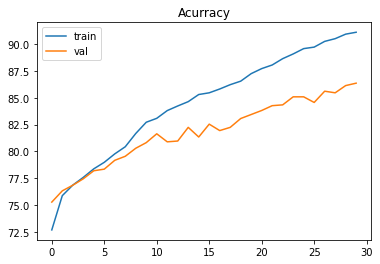

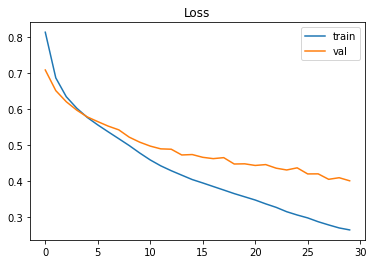

In [25]:
import matplotlib.pyplot as plt

plt.plot([epoch for epoch in range(epochs)], [acc for  acc,loss in bi_train], label='train')
plt.plot([epoch for epoch in range(epochs)], [acc for  acc,loss in bi_valid], label='val')
plt.title('Acurracy')
plt.legend()
plt.show()

plt.plot([epoch for epoch in range(epochs)], [loss for acc,loss in bi_train], label='train')
plt.plot([epoch for epoch in range(epochs)], [loss for acc,loss in bi_valid], label='val')
plt.title('Loss')
plt.legend()
plt.show()

# 89.事前学習済み言語モデルからの転移学習

In [27]:
!pip install transformers

     |████████████████████████████████| 2.5MB 7.8MB/s 
     |████████████████████████████████| 901kB 49.3MB/s 
     |████████████████████████████████| 3.3MB 47.3MB/s 


In [28]:
import matplotlib.pyplot as plt
import pandas as pd
from transformers import BertTokenizer, BertModel

In [29]:
class BERTDataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.y)
  
  def __getitem__(self, index):
    text = self.X[index]
    #入力テキストの前処理、指定した最長系列長までパディング
    inputs = self.tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length = self.max_len,
        pad_to_max_length = True,
        truncation=True,
      #  padding= 'longest'
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']

    return {
        'ids' : torch.LongTensor(ids),
        'mask' : torch.LongTensor(mask),
        'labels' : torch.Tensor(self.y[index])
    }



In [56]:
max_len = 20
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
batch_size = 64

ytrain = torch.nn.functional.one_hot(torch.from_numpy(train_t.numpy())).to(torch.float)
yvalid = torch.nn.functional.one_hot(torch.from_numpy(valid_t.numpy())).to(torch.float)
ytest = torch.nn.functional.one_hot(torch.from_numpy(test_t.numpy())).to(torch.float)


train_dataset = BERTDataset(df_train,ytrain,tokenizer, max_len)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_dataset = BERTDataset(df_valid,yvalid,tokenizer, max_len)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)
test_dataset  = BERTDataset(df_test ,ytest ,tokenizer, max_len)
test_dataloader  = DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = False)

for var in train_dataset[0]:
  print(f'{var}: {train_dataset[0][var]}')

ids: tensor([  101,  3782,  2829,  1011,  3782,  2829,  1005,  1055,  6884,  6101,
         6778,  3231, 14144,  2004,  3979,  4269,   102,     0,     0,     0])
mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0])
labels: tensor([0., 0., 1., 0.])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [31]:
class BERTClass(torch.nn.Module):
  def __init__(self, drop_rate, output_size):
    super().__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased',return_dict=False)
    self.drop = torch.nn.Dropout(drop_rate)
    self.fc = torch.nn.Linear(768, output_size)

  def forward(self, ids, mask):
    _, out = self.bert(ids, attention_mask = mask)
    out = self.drop(out)
    out = self.fc(out)
    return out

In [44]:
def BERTtrain_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  train_loss, correct = 0, 0
  for data in dataloader:
    X, mask, y = data['ids'].to(device), data['mask'].to(device), data['labels'].to(device)
    pred = model(X, mask)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    train_loss += loss_fn(pred, y).item()
    pred = torch.argmax(pred, dim=-1).cpu().numpy()
    labels = torch.argmax(y, dim=-1).cpu().numpy()
    correct += (pred == labels).sum().item()
        
  train_loss /= size
  correct /= size

  print(f"Accracy: {(100*correct):>0.1f}%, Avg loss: {train_loss: > 8f}")
    
  return 100*correct, train_loss

def BERTtest_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  test_loss,correct = 0, 0

  with torch.no_grad():
    for data in dataloader:
      X, mask , y = data['ids'].to(device), data['mask'].to(device), data['labels'].to(device)
      pred = model(X, mask)

      test_loss += loss_fn(pred, y).item()
      pred = torch.argmax(pred, dim=-1).cpu().numpy()
      labels = torch.argmax(y, dim=-1).cpu().numpy()
      
      correct += (pred == labels).sum().item()
  test_loss /= size
  correct /= size

  print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    
  return 100*correct, test_loss

In [45]:
dropout_rate = 0.5
output_dim = 4
epochs = 5

model = BERTClass(dropout_rate, output_dim).to(device)

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
epochs = 5
bert_train = []
bert_valid = []
for t in range(epochs):
    print(f"Epoch {t+1}-------------------------------")
    train_acc , train_loss = BERTtrain_loop(train_dataloader, model, loss_fn, optimizer)
    valid_acc , valid_loss = BERTtest_loop(valid_dataloader, model, loss_fn)
    bert_train.append((train_acc,train_loss))
    bert_valid.append((valid_acc,valid_loss))
print("Done!")

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch 1-------------------------------
Accracy: 79.2%, Avg loss:  0.004796
Test Error: Accuracy: 90.9%, Avg loss: 0.002685
Epoch 2-------------------------------
Accracy: 93.9%, Avg loss:  0.001867
Test Error: Accuracy: 93.6%, Avg loss: 0.001874
Epoch 3-------------------------------
Accracy: 97.0%, Avg loss:  0.001095
Test Error: Accuracy: 93.5%, Avg loss: 0.001746
Epoch 4-------------------------------
Accracy: 98.4%, Avg loss:  0.000677
Test Error: Accuracy: 94.0%, Avg loss: 0.001583
Epoch 5-------------------------------
Accracy: 99.2%, Avg loss:  0.000455
Test Error: Accuracy: 94.5%, Avg loss: 0.001571
Done!


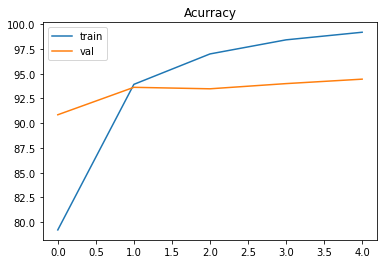

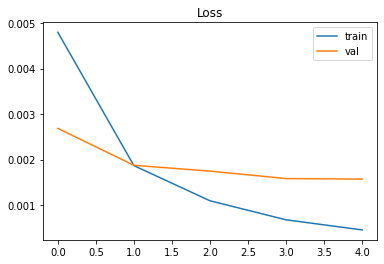

In [48]:
plt.plot([epoch for epoch in range(epochs)], [acc for acc, loss in bert_train], label='train')
plt.plot([epoch for epoch in range(epochs)], [acc for acc, loss in bert_valid], label='val')
plt.title('Acurracy')
plt.legend()
plt.show()

plt.plot([epoch for epoch in range(epochs)], [loss for acc, loss in bert_train], label='train')
plt.plot([epoch for epoch in range(epochs)], [loss for acc, loss in bert_valid], label='val')
plt.title('Loss')
plt.legend()
plt.show()

In [60]:
def calculate_accuracy(model, dataset, device):

  total = 0
  correct = 0
  with torch.no_grad():
    for data in dataset:
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      outputs = model.forward(ids, mask)
      pred = torch.argmax(outputs, dim=-1).cpu().numpy()
      labels = torch.argmax(labels, dim=-1).cpu().numpy()
      total += len(labels)
      correct += (pred == labels).sum().item()

  return correct / total

In [61]:
print(f'正解率（評価データ）：{calculate_accuracy(model, test_dataloader, device):.3f}')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


正解率（評価データ）：0.933
